## ARIMA MODEL


In [63]:
'''




***use AIC or BIC to find optimum parameters for AMRIMA(p,d,q)

***add adf test before the data goes into the model to test the stationarity of the data




PICK UP NOTES

The single candle infront predicts seem fine although useless. predicting man future candles at once seems to be a bigger problem. the predictions converge after a short time

IDENTIFIED THAT THERE ARE SEVERAL MISSING VALUES AND DIFFERENT PLACES THROUGHOUT THE DATA. TRY YFINANCE IMPORT INSTEAD OF DIRECT FROM BINANCE
'2020-02-19 12:00:00' THIS IS THE FINAL DATE WITH ERROR AS A BACK UP YOU COULD JUST USE ALL DATA AFTER THIS



instead of dropping rows after logging data use a forward or a back fill to keep the row


use AIC or BIC to find optimum parameters for AMRIMA(p,d,q)


add evaluation metrics that are appropriate

look at acf and pacf of residuals

try to forecast further into the future

try ligth GMB model


the model makes the same prediction after a while WHY??




'''


"\n\nchanges made in the current session:\n\nchanged the test and cv datasets to be logged before going into ARIMA model\n\n\n\n\n\nPICK UP NOTES\n\nIDENTIFIED THAT THERE ARE SEVERAL MISSING VALUES AND DIFFERENT PLACES THROUGHOUT THE DATA. TRY YFINANCE IMPORT INSTEAD OF DIRECT FROM BINANCE\n'2020-02-19 12:00:00' THIS IS THE FINAL DATE WITH ERROR AS A BACK UP YOU COULD JUST USE ALL DATA AFTER THIS\n\n\n\ninstead of dropping rows after logging data use a forward or a back fill to keep the row\n\n\nuse AIC or BIC to find optimum parameters for AMRIMA(p,d,q)\n\n\nadd evaluation metrics that are appropriate\n\nlook at acf and pacf of residuals\n\ntry to forecast further into the future\n\ntry ligth GMB model\n\nadd adf test before the data goes into the model to test the stationarity of the data\n\nthe model makes the same prediction after a while WHY??\n\n\n\n\n"

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,accuracy_score,roc_auc_score,precision_score,recall_score
from math import sqrt
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import regularizers

import keras_tuner as kt
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.metrics import Precision,Recall,AUC

from pandas.plotting import autocorrelation_plot
from time import time

## Read in the data and set random seed

In [65]:
df = pd.read_csv("prepared_data.csv")
df = df.set_index(["timestamp"])
np.random.seed(42)
df.index = pd.to_datetime(df.index)
   



## Set the frequency of the data

In [66]:
df = df.asfreq("4H")
df = df["2020-02-20 00:00:00":]
df.index.freq

<4 * Hours>

## Check for missing data

In [67]:
null_indexes = df[df.isnull().any(axis=1)].index
null_indexes

DatetimeIndex([], dtype='datetime64[ns]', name='timestamp', freq='4H')

In [68]:
df.isnull().sum()

open          0
high          0
low           0
close         0
volume        0
rsi 10        0
rsi 14        0
rsi 20        0
rsi 30        0
obv           0
atr           0
lowest        0
highest       0
net_change    0
y             0
dtype: int64

## Remove the first few rows so that first instance is at midnight

In [70]:
X = pd.DataFrame(df["close"])
X.index.freq

<4 * Hours>

In [71]:
X.isnull().sum()

close    0
dtype: int64

## Split the data into train and test ensuring the split is at midnight

In [72]:
'''
split_distance = int(0.9 * len(X))-3
train, test = X.iloc[:split_distance], X.iloc[split_distance:]
'''

split_distance = int(0.8 * len(X))-3
test_split = int(0.9 * len(X))-3
print(split_distance)
train,cv, test = X.iloc[:split_distance], X.iloc[split_distance:test_split],X.iloc[test_split:]

6930


In [73]:
print(f"length of X:{len(X)}")
print(f"length of train:{len(train)}")
print(f"length of CV:{len(cv)}")
print(f"length of test:{len(test)}")
test_split

length of X:8667
length of train:6930
length of CV:867
length of test:870


7797

In [74]:
train.isnull().sum()

close    0
dtype: int64

## Check the shape of train, cv and test

In [75]:
f"Train shape:{train.shape}"

'Train shape:(6930, 1)'

In [76]:
f"Cv shape:{cv.shape}"

'Cv shape:(867, 1)'

In [77]:
f"Test shape:{test.shape}"

'Test shape:(870, 1)'

## Check that indexing is set properly

In [78]:
type(train.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [79]:
type(cv.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [80]:
type(test.index)

pandas.core.indexes.datetimes.DatetimeIndex

## Make data stationary for ACF and PACF 

In [81]:
df["close_transformed"] = np.log(df["close"]).diff()
df.dropna(inplace = True)

In [82]:
df["close_transformed"]

timestamp
2020-02-20 04:00:00    0.003726
2020-02-20 08:00:00   -0.004365
2020-02-20 12:00:00    0.000927
2020-02-20 16:00:00   -0.002332
2020-02-20 20:00:00    0.004644
                         ...   
2024-02-02 16:00:00   -0.004174
2024-02-02 20:00:00    0.003200
2024-02-03 00:00:00   -0.000603
2024-02-03 04:00:00   -0.002804
2024-02-03 08:00:00   -0.001348
Freq: 4H, Name: close_transformed, Length: 8666, dtype: float64

## Run ACF to assist choosing values for errors

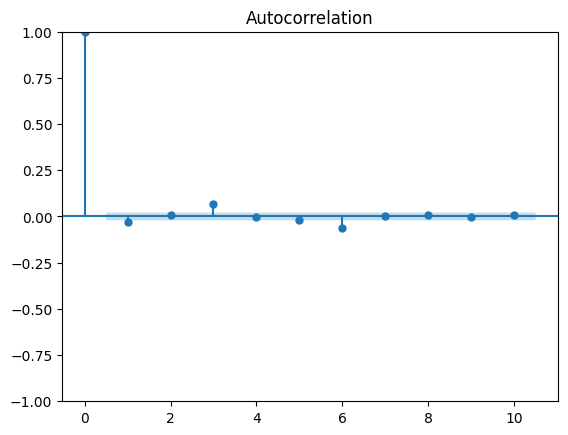

In [83]:
plot_acf(df["close_transformed"],lags=10)
plt.show()

## Run PACF to assist choosing values for lags

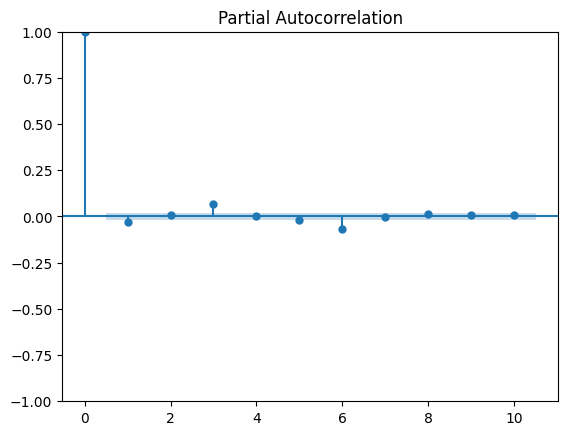

In [84]:
plot_pacf(df["close_transformed"],lags=10)
plt.show()

## Apply a log transformation to stabilise the variance of the data. 

In [86]:
train = np.log(train["close"])
train = pd.DataFrame(train)

cv = np.log(cv["close"])
cv = pd.DataFrame(cv)

test = np.log(test["close"])
test = pd.DataFrame(test)

                         close
timestamp                     
2020-02-20 00:00:00   9.166545
2020-02-20 04:00:00   9.170271
2020-02-20 08:00:00   9.165907
2020-02-20 12:00:00   9.166834
2020-02-20 16:00:00   9.164502
...                        ...
2023-04-19 04:00:00  10.311541
2023-04-19 08:00:00  10.285706
2023-04-19 12:00:00  10.283992
2023-04-19 16:00:00  10.282851
2023-04-19 20:00:00  10.268030

[6930 rows x 1 columns]                          close
timestamp                     
2023-04-20 00:00:00  10.270299
2023-04-20 04:00:00  10.270546
2023-04-20 08:00:00  10.261411
2023-04-20 12:00:00  10.257894
2023-04-20 16:00:00  10.243681
...                        ...
2023-09-10 16:00:00  10.158130
2023-09-10 20:00:00  10.159741
2023-09-11 00:00:00  10.155817
2023-09-11 04:00:00  10.158659
2023-09-11 08:00:00  10.150397

[867 rows x 1 columns]                          close
timestamp                     
2023-09-11 12:00:00  10.131259
2023-09-11 16:00:00  10.127457
2023-09-11 20:00:00  

## Check the indexes are still Datetime Indexes

In [87]:
type(train.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [88]:
type(cv.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [89]:
type(test.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [90]:
start = cv.index[0]
end = cv.index[-1]

In [91]:
start

Timestamp('2023-04-20 00:00:00', freq='4H')

In [92]:
end

Timestamp('2023-09-11 08:00:00', freq='4H')

## Find the best values for  (p,d,q)

In [93]:
## CHECK THE NOTES AT THE TOP AS TO HOW TO DO THIS

## Inspect Train, CV, and Test before they go into the model

In [94]:

print("Train:")
print(f"{train}/n{print(type(train))}\n")

print("CV:")
print(f"{cv}/n{print(type(cv))}\n")

print("Test:")
print(f"{test}/n{print(type(test))}")

Train:
<class 'pandas.core.frame.DataFrame'>
                         close
timestamp                     
2020-02-20 00:00:00   9.166545
2020-02-20 04:00:00   9.170271
2020-02-20 08:00:00   9.165907
2020-02-20 12:00:00   9.166834
2020-02-20 16:00:00   9.164502
...                        ...
2023-04-19 04:00:00  10.311541
2023-04-19 08:00:00  10.285706
2023-04-19 12:00:00  10.283992
2023-04-19 16:00:00  10.282851
2023-04-19 20:00:00  10.268030

[6930 rows x 1 columns]/nNone

CV:
<class 'pandas.core.frame.DataFrame'>
                         close
timestamp                     
2023-04-20 00:00:00  10.270299
2023-04-20 04:00:00  10.270546
2023-04-20 08:00:00  10.261411
2023-04-20 12:00:00  10.257894
2023-04-20 16:00:00  10.243681
...                        ...
2023-09-10 16:00:00  10.158130
2023-09-10 20:00:00  10.159741
2023-09-11 00:00:00  10.155817
2023-09-11 04:00:00  10.158659
2023-09-11 08:00:00  10.150397

[867 rows x 1 columns]/nNone

Test:
<class 'pandas.core.frame.DataFrame'>


## Set list to receive model prediction set sample length variable

In [95]:
model_predictions = []

#number of test observations
n_cv = len(cv)
n_cv


867

In [96]:
warnings.filterwarnings("ignore", category=ValueWarning, module="statsmodels.tsa.base.tsa_model")

## Train the model with an expanding window while generating forecasts

In [98]:
counter = 1
#for as many times as we have samples
for i in range(n_cv):
    print(f"running {counter} out of {n_cv}")

    #train the model on the window
    model = ARIMA(train,order = (3,1,0))
    model_fit = model.fit()

    #generate forecast for next candle
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)

    #add the current candle to the train set and expand the window
    actual_cv_value = cv["close"].iloc[i]
    new_index = cv.index[i]
    train.loc[new_index] = actual_cv_value 
    
    print(f"yhat ={yhat}")
    counter += 1
    

running 1 out of 867
yhat =10.268416592910876
running 2 out of 867
yhat =10.27002187492706
running 3 out of 867
yhat =10.269526848357378
running 4 out of 867
yhat =10.26188854139266
running 5 out of 867
yhat =10.25796012642837
running 6 out of 867
yhat =10.243510403601935
running 7 out of 867
yhat =10.248092732566123
running 8 out of 867
yhat =10.250330141766154
running 9 out of 867
yhat =10.246051835886798
running 10 out of 867
yhat =10.242575099569496
running 11 out of 867
yhat =10.241008909676655
running 12 out of 867
yhat =10.214633421850031
running 13 out of 867
yhat =10.21301530398856
running 14 out of 867
yhat =10.213458268351488
running 15 out of 867
yhat =10.213857389925973
running 16 out of 867
yhat =10.214279703142527
running 17 out of 867
yhat =10.221171825906232
running 18 out of 867
yhat =10.22630393993132
running 19 out of 867
yhat =10.233707806556206
running 20 out of 867
yhat =10.224760837527446
running 21 out of 867
yhat =10.230079389205262
running 22 out of 867
yhat 

'\n#this code works predicting nextc andle value\n\ncounter = 1\n#for as many times as we have samples\nfor i in range(n_cv):\n    print(f"running {i} out of {n_cv}")\n\n    #train the model on the window\n    model = ARIMA(train,order = (3,1,0))\n    model_fit = model.fit()\n\n    #generate forecast for next candle\n    output = model_fit.forecast()\n    yhat = output[0]\n    model_predictions.append(yhat)\n\n    #add the current candle to the train set and expand the window\n    actual_cv_value = cv["close"].iloc[i]\n    new_index = cv.index[i]\n    train.loc[new_index] = actual_cv_value \n    \n    print(f"yhat ={yhat}")\n    #print(train.tail())\n    counter += 1\n    #if counter == 10:\n       # break\n\n'

## Examine the summary from of the model

In [100]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 7796
Model:                 ARIMA(3, 1, 0)   Log Likelihood               21825.999
Date:                Tue, 13 Feb 2024   AIC                         -43643.998
Time:                        16:11:39   BIC                         -43616.153
Sample:                    02-20-2020   HQIC                        -43634.455
                         - 09-11-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0340      0.007     -4.986      0.000      -0.047      -0.021
ar.L2          0.0067      0.006      1.052      0.293      -0.006       0.019
ar.L3          0.0689      0.005     13.834      0.0

## Inspect the Train,CV and Test

In [101]:
print("Train:")
print(f"{train}/n{print(type(train))}\n")

print("CV:")
print(f"{cv}/n{print(type(cv))}\n")

print("Test:")
print(f"{test}/n{print(type(test))}")

Train:
<class 'pandas.core.frame.DataFrame'>
                         close
timestamp                     
2020-02-20 00:00:00   9.166545
2020-02-20 04:00:00   9.170271
2020-02-20 08:00:00   9.165907
2020-02-20 12:00:00   9.166834
2020-02-20 16:00:00   9.164502
...                        ...
2023-09-10 16:00:00  10.158130
2023-09-10 20:00:00  10.159741
2023-09-11 00:00:00  10.155817
2023-09-11 04:00:00  10.158659
2023-09-11 08:00:00  10.150397

[7797 rows x 1 columns]/nNone

CV:
<class 'pandas.core.frame.DataFrame'>
                         close
timestamp                     
2023-04-20 00:00:00  10.270299
2023-04-20 04:00:00  10.270546
2023-04-20 08:00:00  10.261411
2023-04-20 12:00:00  10.257894
2023-04-20 16:00:00  10.243681
...                        ...
2023-09-10 16:00:00  10.158130
2023-09-10 20:00:00  10.159741
2023-09-11 00:00:00  10.155817
2023-09-11 04:00:00  10.158659
2023-09-11 08:00:00  10.150397

[867 rows x 1 columns]/nNone

Test:
<class 'pandas.core.frame.DataFrame'>


## Combine the train and cv set to provide training for test set and train the new model
## Fit and make forecasts for the Test date range

In [102]:
# Combine train and CV data
train_cv_combined = pd.concat([train, cv])

#fit model
final_model = ARIMA(train_cv_combined, order=(3,1,0))
final_model_fit = final_model.fit()

# Make out-of-sample forecasts on the test set
test_forecast = final_model_fit.forecast(steps=len(test))

8664    10.150425
8665    10.150574
8666    10.150013
8667    10.150035
8668    10.150041
          ...    
9529    10.150004
9530    10.150004
9531    10.150004
9532    10.150004
9533    10.150004
Name: predicted_mean, Length: 870, dtype: float64


C:\Users\dariu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Inspect the inputs and outputs at the testing phase and cv phase

In [103]:
# Get data here to be uniform


#predictions for the cv set
print("Model Predictions:")
print(f"{model_predictions}/n{print(type(model_predictions))}\n")

#training set for the test set
print("Train-CV Combined::")
print(f"{train_cv_combined}/n{print(type(train_cv_combined))}\n")

#predictions for the test set
print("Test Forecast:")
print(f"{test_forecast}/n{print(type(test_forecast))}\n")

Model Predictions:
<class 'list'>
[10.268416592910876, 10.27002187492706, 10.269526848357378, 10.26188854139266, 10.25796012642837, 10.243510403601935, 10.248092732566123, 10.250330141766154, 10.246051835886798, 10.242575099569496, 10.241008909676655, 10.214633421850031, 10.21301530398856, 10.213458268351488, 10.213857389925973, 10.214279703142527, 10.221171825906232, 10.22630393993132, 10.233707806556206, 10.224760837527446, 10.230079389205262, 10.22661595107664, 10.221608080873363, 10.220466299196248, 10.224645132554242, 10.2322128728019, 10.22099247332043, 10.224066928413075, 10.212971656298196, 10.217705821017631, 10.221491642337963, 10.216858437422687, 10.213791201984534, 10.217367599516095, 10.216182519738267, 10.225949230381834, 10.24975092472276, 10.251802215625396, 10.254941941739302, 10.272748978665186, 10.3022530773354, 10.239817289530034, 10.25555977998076, 10.265933666324011, 10.272808812970698, 10.27388114684475, 10.279964003283407, 10.297537861738236, 10.292110574954881,

## Untransform the needed inputs and outputs

In [116]:
test_forecast.head(30)

8664    25601.974672
8665    25605.808281
8666    25591.443375
8667    25591.992543
8668    25592.161317
8669    25591.191394
8670    25591.261812
8671    25591.266029
8672    25591.200928
8673    25591.207879
8674    25591.207609
8675    25591.203269
8676    25591.203881
8677    25591.203821
8678    25591.203534
8679    25591.203584
8680    25591.203577
8681    25591.203558
8682    25591.203562
8683    25591.203562
8684    25591.203560
8685    25591.203561
8686    25591.203561
8687    25591.203561
8688    25591.203561
8689    25591.203561
8690    25591.203561
8691    25591.203561
8692    25591.203561
8693    25591.203561
Name: predicted_mean, dtype: float64

In [104]:
#for the cv vs predictions
#is it messing with types match ups that this is a list?
model_predictions = [np.exp(i) for i in model_predictions]
cv = np.exp(cv)

#for test vs predictions
test = np.exp(test)
test_forecast = np.exp(test_forecast)

## Take a look here if untransformation worked

In [105]:

print("Model Predictions unlogged:")
print(f"{model_predictions}/n{print(type(model_predictions))}\n")

print("Test unlogged:")
print(f"{test}/n{print(type(test))}\n")

print("CV unlogged:")
print(f"{cv}/n{print(type(cv))}\n")

print("Test forecast unlogged:")
print(f"{test_forecast}/n{print(type(test_forecast))}\n")
      

Model Predictions unlogged:
<class 'list'>
[28808.235868832606, 28854.51835006934, 28840.23813166605, 28620.786725449885, 28508.572954028357, 28099.5939096051, 28228.650957758473, 28291.880710153353, 28171.09794760753, 28073.324532953542, 28029.390789084984, 27299.766331481587, 27255.627812260438, 27267.70375847997, 27278.589059471393, 27290.111601049684, 27478.848050727407, 27620.235129178003, 27825.49057055117, 27577.64714521558, 27724.711023462096, 27628.85429494264, 27490.838449926003, 27459.467826904707, 27574.4564588843, 27783.924382556994, 27473.9200902091, 27558.517402427628, 27254.438193019287, 27383.771092832332, 27487.637643312202, 27360.576363245153, 27276.78360556649, 27374.51087874562, 27342.08911445835, 27610.43970538653, 28275.498315595418, 28333.5591174961, 28422.658533644742, 28933.315009420923, 29799.684265961394, 27996.010294707918, 28440.224564934906, 28736.795860922564, 28935.046266024423, 28966.090938434823, 29142.824488664413, 29659.50308189634, 29498.9684805304

## Set up time range of dates for cv for the plot

In [106]:
pred_start_date = pd.to_datetime(cv.index[0])
pred_end_date =pd.to_datetime(cv.index[-1])
cv_time_range = pd.date_range(pred_start_date,pred_end_date,freq="4H")

cv_time_range

DatetimeIndex(['2023-04-20 00:00:00', '2023-04-20 04:00:00',
               '2023-04-20 08:00:00', '2023-04-20 12:00:00',
               '2023-04-20 16:00:00', '2023-04-20 20:00:00',
               '2023-04-21 00:00:00', '2023-04-21 04:00:00',
               '2023-04-21 08:00:00', '2023-04-21 12:00:00',
               ...
               '2023-09-09 20:00:00', '2023-09-10 00:00:00',
               '2023-09-10 04:00:00', '2023-09-10 08:00:00',
               '2023-09-10 12:00:00', '2023-09-10 16:00:00',
               '2023-09-10 20:00:00', '2023-09-11 00:00:00',
               '2023-09-11 04:00:00', '2023-09-11 08:00:00'],
              dtype='datetime64[ns]', length=867, freq='4H')

## Set up time range of dates for test set for the plot

In [107]:
#test predictions
test_pred_start_date = pd.to_datetime(test.index[0])
test_pred_end_date =pd.to_datetime(test.index[-1])
test_time_range = pd.date_range(test_pred_start_date,test_pred_end_date,freq="4H")

## Check the length of everything for the plots

In [108]:
len(cv_time_range)

867

In [109]:
len(model_predictions)

867

In [110]:
len(test_time_range)

870

In [111]:
len(test_forecast)

870

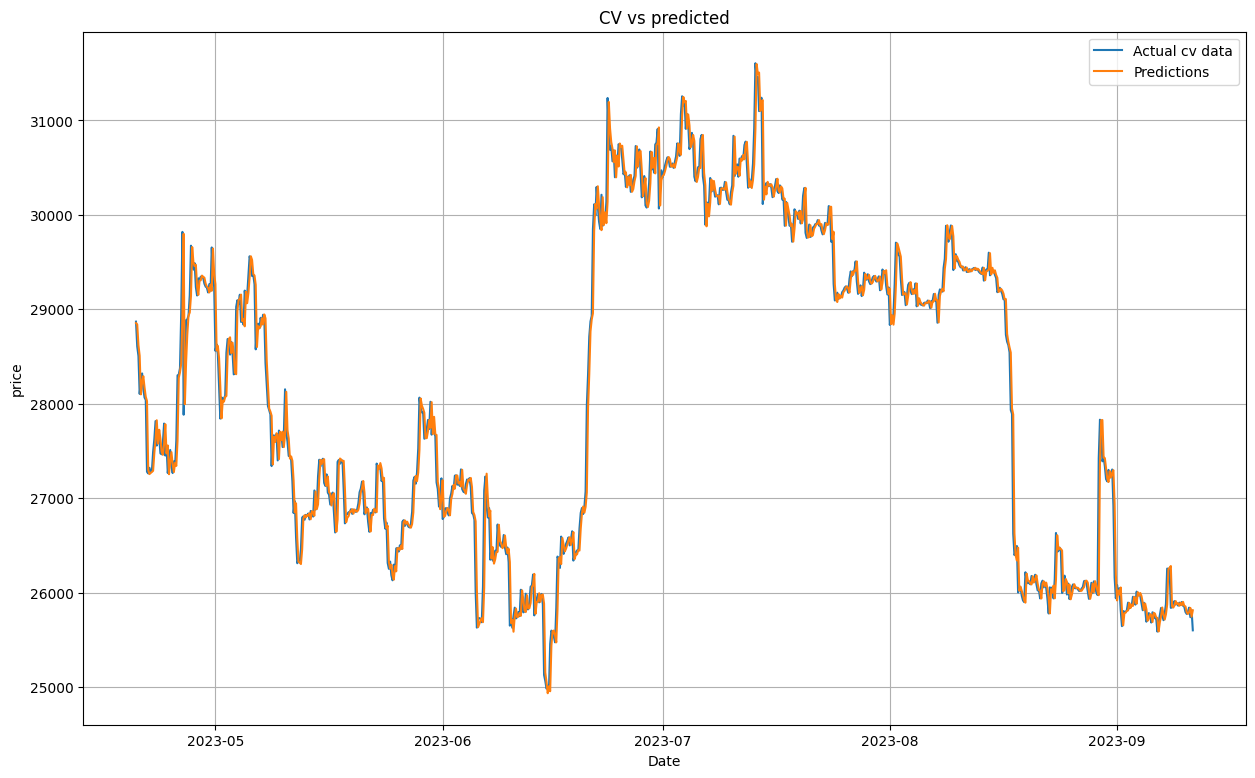

In [119]:
#the first prediction is messing up the plots so skip the first plot with batch
batch = 1

plt.figure(figsize=(15,9))
plt.grid(True)
plt.plot(cv_time_range[batch:],cv[batch:], label = "Actual cv data")
plt.plot(cv_time_range[batch:],model_predictions[batch:], label = "Predictions")
plt.title("CV vs predicted")
plt.xlabel("Date")
plt.ylabel("price")
plt.legend()
plt.show()

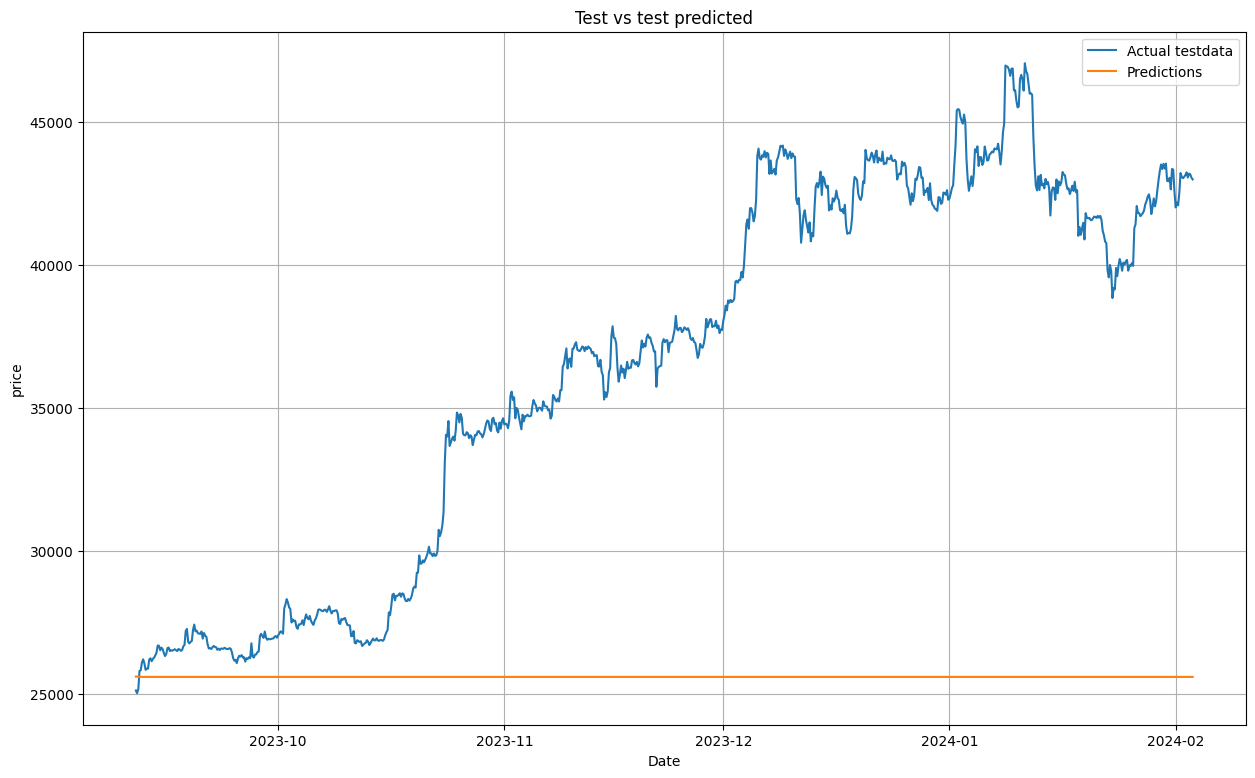

In [118]:
plt.figure(figsize=(15,9))
plt.grid(True)
plt.plot(test_time_range[batch:],test[batch:], label = "Actual testdata")
plt.plot(test_time_range[batch:],test_forecast[batch:], label = "Predictions")
plt.title("Test vs test predicted")
plt.xlabel("Date")
plt.ylabel("price")
plt.legend()
plt.show()

## Make predictions and print the residuals

In [120]:
corelation_matrix= np.corrcoef(model_predictions,cv["close"])
corelation_matrix

array([[1.       , 0.9916287],
       [0.9916287, 1.       ]])

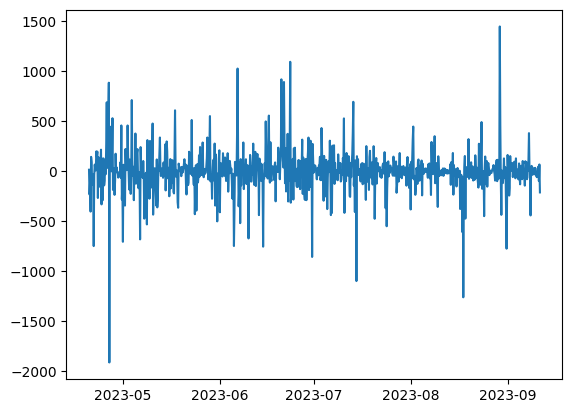

In [121]:
residuals = cv["close"] - model_predictions
residuals
plt.plot(residuals[1:])